# Dataset Description

Our analysis is based on the **Spotify Million Playlist Dataset (MPD)**, introduced as part of the RecSys Challenge 2018 by Spotify Research [1]. The dataset contains **1,000,000 user-generated playlists**, sampled from over 4 billion public playlists created on the Spotify platform between January 2010 and November 2017. Each playlist includes metadata such as playlist title, number of tracks, number of albums, and duration, as well as detailed track-level information including track name, artist name, album name, and track duration. In total, the MPD comprises **over 2 million unique tracks by nearly 300,000 artists**. Playlists were sampled with randomization and manually filtered to ensure quality and remove offensive content [2].

In our report we have decided to use the first 1000 playlists as the foundation for our network. 

To enrich the network with semantic information, we scraped lyrics for the tracks associated with each artist from the Genius website[3] using a Genius API[4]. For each artist, we collected the full text of their songs, including verses, choruses, and bridges, and stored them in plain text files. These files were aggregated at the artist level, resulting in a single combined lyric corpus per artist.

**References**  
[1] Spotify Research. *The Million Playlist Dataset Challenge*. RecSys Challenge 2018. Available at: https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge#dataset
[2] McFee, B., et al. (2018). *The Million Playlist Dataset Challenge*. Proceedings of the ACM RecSys Challenge 2018.  
[3] https://genius.com/  
[4] https://lyricsgenius.readthedocs.io/en/master/reference/genius.html  

# Loading the playlist and Genius data into dataframes

OBS! The following code is cannot be run, but it ends up saving our graph to as a .graphml file, and this is what we use later on.

In [1]:
import networkx as nx
from collections import defaultdict
from itertools import combinations
from pathlib import Path
import lyricsgenius
import os
import re
import time
import json
import pandas as pd
import backboning as bb  # assuming backboning.py is in your PYTHONPATH
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import numpy as np

The code was run on local data since it would take to long to run id the data pulled from github. But the data used can be found at the link below: 

https://github.com/noanorgaard/SocialGraphs/tree/006325ea733c5c130df01bd196f250106b6e2f64/Project/artist_lyrics_cleaned

---

```Python
# number of playlist to process out of the slice files
NUM_PLAYLISTS = 1000

# Path to your original slice file
folder_path = Path(r"/Users/noa/Desktop/02805 - Social Graphs/playlist_data/") 

# folder with artist/lyrics files
artist_folder = Path(r"/Users/noa/Desktop/02805 - Social Graphs/artist_lyrics_cleaned") 

# Load all mpd slice JSON files in the folder and merge their playlists
file_list = sorted(folder_path.glob("mpd.slice.*.json"))
playlists = []
for fp in file_list:
    with open(fp, 'r', encoding='utf-8') as f:
        data = json.load(f)
        playlists.extend(data.get("playlists", []))

print(f"Loaded {len(file_list)} files, total playlists merged: {len(playlists[:])}")

----
OUTPUT
----
Loaded 1 files, total playlists merged: 1000

We have decided to filter out some of the playlists using the following criteria:
- A playlist should contain between 20 and 100 songs
  - This is done such that we don't have playlists without themes, as we expect playlists of length > 100 to be more randomly sampled and less curated.
  - Playlists of less than 20 songs might not have enough songs for it to have thematic meaning.
- Each playlist should contain at least 6 different artists. 
  - this is done to ensure variety in the playlists.

```Python
# Accumulators
artist_songs = defaultdict(set)
artist_playlists = defaultdict(set)
artist_albums = defaultdict(set)
artist_durations = defaultdict(list)
edge_playlists = defaultdict(set)

def normalize_artist_name(name):
    if not name:
        return None
    return name.replace(' ', '_').strip()

included_playlists = 0

for pl in playlists[:NUM_PLAYLISTS]:
    pid = pl.get("pid")
    tracks = pl.get("tracks", [])
    # filter playlists by track count and unique artist count
    if not (20 <= len(tracks) <= 100):
        continue

    # build normalized set of unique artists for this playlist
    unique_artists = {normalize_artist_name(t["artist_name"]) for t in tracks if t.get("artist_name")}
    unique_artists = {a for a in unique_artists if a}  # drop Nones/empty
    if len(unique_artists) < 6:
        continue

    included_playlists += 1

    # collect songs, albums, durations, playlist membership per artist
    for t in tracks:
        raw_artist = t.get("artist_name")
        artist = normalize_artist_name(raw_artist)
        if not artist:
            continue
        track_name = t.get("track_name")
        album_name = t.get("album_name")
        duration = t.get("duration_ms")

        if track_name:
            artist_songs[artist].add(track_name)
        if album_name:
            artist_albums[artist].add(album_name)
        if duration:
            artist_durations[artist].append(duration)
        artist_playlists[artist].add(pid)

    # increment edge counters for every pair of (normalized) artists in this playlist
    for a, b in combinations(sorted(unique_artists), 2):
        edge_playlists[(a, b)].add(pid)

print(f"Included playlists: {included_playlists}")

----
OUTPUT
----
Included playlists: 583

The assumptions have filtered out approximately half of the playlists. It is important to remark that the lyrics that is added to all artists as an attribute, is the scraping from all 1000 playlists text from Genius.

## Scrape the lyrics

OBS! This code was run on the HPC and all concatenated lyrics were saved in txt files.

We have had these considerations
- Avoid duplicates: Only fetch lyrics for unique songs per artist.
- Rate limits: Genius API has limits, so we have needed to add delays.

```Python
import json
from pathlib import Path
import lyricsgenius
import os
import re
import time
from collections import defaultdict

# Folder to save lyrics
lyrics_folder = Path("artist_lyrics")
lyrics_folder.mkdir(exist_ok=True)

# Setup Genius API
GENIUS_ACCESS_TOKEN = "IKoqZN1ANyU_2G6zmTPF2xlaH2OlIEEUlDoD97Mo9-P_A6-2QgnSoQlwsJ3Hy3DY"

# Initialize Genius client
genius = lyricsgenius.Genius(
    GENIUS_ACCESS_TOKEN,
    remove_section_headers=True,   # cleans up [Verse], etc.
    timeout=15,
    retries=3
)

artist_lyrics = defaultdict(str)

for artist, songs in artist_songs.items():
    for track_name in songs:
        try:
            song = genius.search_song(track_name, artist)
            if song and song.lyrics:
                artist_lyrics[artist] += "\n" + song.lyrics
        except Exception as e:
            print(f"Error retrieving {track_name} by {artist}: {e}")
        time.sleep(1)  # Avoid hitting rate limits

# Save lyrics to files
for artist, lyrics in artist_lyrics.items():
    safe_name = re.sub(r'[^\w\s-]', '', artist).strip().replace(' ', '_')
    file_path = lyrics_folder / f"{safe_name}.txt"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(lyrics)

## Clean and load lyrics for all artists

Below is the functions we have used to clean all our lyrics

In [2]:
import re
from pathlib import Path
from typing import Iterable, Union
import argparse

def remove_metadata_blocks_from_text(text: str) -> str:
    """
    Remove metadata blocks from a text.
    Returns the cleaned text.
    """
    lines = text.splitlines(keepends=True)
    out_lines = []
    i = 0

    # match any line that starts with optional spaces, then digits, then 'Contributors'
    pattern = re.compile(r'^\s*\d+\s+Contributors')  # matches start of metadata block

    #match any contiguous non-space "word" that ends with 'Embed'
    embed_pat = re.compile(r'\b\S+Embed\b', re.IGNORECASE)

    while i < len(lines):
        # remove tokens like '87Embed' but NOT standalone 'Embed'
        line = embed_pat.sub('', lines[i])

        if pattern.match(line):
            # skip this metadata line and subsequent non-blank lines
            i += 1
            while i < len(lines) and lines[i].strip() != "":
                i += 1
            # if there's a blank line, preserve it (to keep stanza breaks)
            if i < len(lines) and lines[i].strip() == "":
                out_lines.append(lines[i])
                i += 1
        else:
            out_lines.append(line)
            i += 1

    return "".join(out_lines)


def process_file(path: Union[str, Path], inplace: bool = True, backup: bool = True, encoding: str = "utf-8") -> str:
    """
    Process a single file. If inplace is True, overwrite the file (optionally making a .bak backup).
    Returns the cleaned text.
    """
    p = Path(path)
    text = p.read_text(encoding=encoding)
    cleaned = remove_metadata_blocks_from_text(text)

    if inplace:
        if backup:
            bak = p.with_suffix(p.suffix + ".bak")
            bak.write_text(text, encoding=encoding)
        p.write_text(cleaned, encoding=encoding)

    return cleaned


def process_paths(paths: Iterable[Union[str, Path]], **kwargs) -> None:
    """
    Process multiple files or directories. If a directory is supplied, all files
    inside (non-recursive) will be processed. kwargs are passed to process_file.
    """
    for p in paths:
        p = Path(p)
        if p.is_dir():
            for child in p.iterdir():
                if child.is_file():
                    process_file(child, **kwargs)
        elif p.is_file():
            process_file(p, **kwargs)

The code was run on local data since it would take to long to run id the data pulled from github. But the data used can be found at the link below: 

https://github.com/noanorgaard/SocialGraphs/tree/006325ea733c5c130df01bd196f250106b6e2f64/Project/artist_lyrics_cleaned

```Python
# Clean all files in a folder
PATH = '/Users/noa/Desktop/02805 - Social Graphs/artist_lyrics_cleaned' 
process_paths([PATH], inplace=True, backup=False, encoding="utf-8")

Now we create the dictionary of the lyrics for each artist

```Python
lyrics_dict = {}

# Load lyrics for artists
for txt_file in artist_folder.glob("*.txt"):
    artist_name = txt_file.stem  # filename without extension
    with open(txt_file, 'r', encoding='utf-8') as f:
        lyrics_dict[artist_name.lower()] = f.read()

## Creating the undirected co-occurence graph
From the MPD, we construct an **artist co-occurrence network** where nodes represent artists and edges represent co-occurrence in playlists. An edge between two artists indicates that they appear together in at least one playlist. 

**Nodes** represent artists.
Node attributes:
- songs: set of track names
- playlists: set of playlist IDs
- num_playlists: count of playlists
- num_songs: count of songs
- avg_song_duration: average track duration
- albums: set of album names
- lyrics: if available (for artists like 2Pac)

**Edges** represent co-occurrence in playlists.
Edge attributes:
- shared_playlists: set of playlist IDs
- weight: number of shared playlists
- co_occurrence_count: number of times they appear together

We are not keeping nodes where:
- the Genius API was not able to find the lyrics of the artist
- Artist that have less than four songs represented in the 1000 playlists

Lastly we only keep the largest connected component as the main graph.

```Python
# Build the graph
G = nx.Graph()

# Add nodes with attributes
for artist in artist_songs.keys():
    num_playlists = len(artist_playlists[artist])
    num_songs = len(artist_songs[artist])
    avg_duration = sum(artist_durations[artist]) / len(artist_durations[artist]) if artist_durations[artist] else None
    lyrics = lyrics_dict.get(artist.lower(), None)

    G.add_node(artist,
               songs=list(artist_songs[artist]),
               albums=list(artist_albums[artist]),
               playlists=list(artist_playlists[artist]),
               num_playlists=num_playlists,
               num_songs=num_songs,
               avg_song_duration=avg_duration,
               lyrics=lyrics)

# Add edges with attributes
for (a, b), pls in edge_playlists.items():
    G.add_edge(a, b,
               shared_playlists=list(pls),
               weight=len(pls),
               co_occurrence_count=len(pls))

# remove nodes where lyrics attribute is missing or empty
nodes_to_remove = [n for n, attrs in G.nodes(data=True) if not attrs.get('lyrics')]

# remove nodes from the graph where num_songs is less than 4 
nodes_to_remove += [n for n, attrs in G.nodes(data=True) if attrs.get('num_songs', 0) < 4]

G.remove_nodes_from(nodes_to_remove) 

# keep largest connected component only
if not nx.is_connected(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()

print(f"After removing artists with no lyrics: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

----
OUTPUT
----
After removing artists with no lyrics: 1015 nodes, 63840 edges

# NC Backbone

Because our network is very dense, we are going to filter out some nodes and edges finding the backbone of the graph. we have chosen to make a Noise-Corrected backbone (NC), as it is well-suited for weighted networks where node activity varies greatly, such as the co-occurrence network of artists. This backbone was introduced by Coscia and Neffke (2017) and their backboning.py file is used to produce the backbone. [1]

The goal is to look at strong connections of artists, i.e. connections where artists are appearing on a significant amount of playlists together. 
In the original graph, hubs (popular artists) accumulate many edges simply because they appear on numerous playlists. For example, the node "Rihanna" is connected to almost half of the other nodes in the original graph. These connections may not all represent meaningful associations. The NC backbone addresses this by comparing each edge weight, $n_{ij}$, to an expected value under a null model that accounts for both nodes’ ($i$'s and $j$'s) overall activity. Edges that are stronger than expected are kept, while those likely due to random co-occurrence are removed.

The NC backbone is chosen over simpler filters (e.g., Disparity Filter) because it accounts for both sending and receiving propensities, making it more robust for co-occurrence data where degree heterogeneity is high.[1,2]
As mentioned, it controls for popularity bias as hubs retain only their most significant ties. Furthermore, it filters less strongly, preserving more nodes and edges than for example the Disparity Filter. [1,2]

The NC backbone assumes independence between node activities, which may not hold in all domains. For the network in question, artist network, we find it acceptable. 
Furthermore centrality/popularity can change in the NC backbone. Though, these properties are not of interest in this paper, therefore removing a potential large amount of edges from hubs, does not have big complications for the analysis.
A potential downfall for our analysis could be the potential loss of some transitivity (measure of how connected a network's nodes are, specifically their tendency to form clusters or groups) in the NC Backbone, as the clusters and groups are of interest.[2]


[1] https://www.michelecoscia.com/?page_id=287.  
[2] https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0316141

The function below uses the package, to create the backbone. The second plots number of edges vs. threshold from the backbone. 

In [3]:
def nc_backbone_from_nx(G, weight_attr="weight", threshold=2.0, calculate_p_value=False):
    """
    Compute Noise-Corrected backbone from an undirected NetworkX graph.

    Args:
        G (nx.Graph): Undirected weighted graph.
        weight_attr (str): Edge attribute name for weights.
        threshold (float): Threshold for backbone extraction.
        calculate_p_value (bool): If True, compute p-values instead of NC score.

    Returns:
        backbone_edges (pd.DataFrame): DataFrame with columns [src, trg, nij, score].
    """
    # 1. Convert NetworkX graph to DataFrame
    edges = []
    for u, v, data in G.edges(data=True):
        w = data.get(weight_attr, 1.0)  # default weight = 1 if missing
        edges.append({"src": u, "trg": v, "weight": w})
    df = pd.DataFrame(edges)

    # 2. Compute NC backbone
    nc_table = bb.noise_corrected(
        df.rename(columns={"weight": "nij"}),  # rename for compatibility
        undirected=True,
        return_self_loops=False,
        calculate_p_value=calculate_p_value
    )

    # 3. Apply thresholding
    backbone = bb.thresholding(nc_table, threshold)

    return backbone


def plot_nc_backbone_thresholds(G, weight_attr="weight", thresholds=None):
    if thresholds is None:
        thresholds = [0.5, 1, 1.5, 2, 2.5, 3]

    # Convert NetworkX graph to DataFrame
    edges = [{"src": u, "trg": v, "nij": data.get(weight_attr, 1.0)}
             for u, v, data in G.edges(data=True)]
    df = pd.DataFrame(edges)

    # Compute NC scores
    nc_table = bb.noise_corrected(df, undirected=True, return_self_loops=False)

    # Calculate edge counts for each threshold
    edge_counts = []
    for t in thresholds:
        backbone = bb.thresholding(nc_table, t)
        edge_counts.append(len(backbone))

    # Plot using Plotly
    fig = px.line(x=thresholds, y=edge_counts, markers=True,
                  labels={'x': 'Threshold', 'y': 'Number of Edges'},
                  title='NC Backbone Edge Count vs Threshold')
    fig.show()

    return thresholds, edge_counts

Firstly we look at the number of edges vs the threshold for the backone construction.  

In [4]:
#  Loading the graph from Github
url = r"https://raw.githubusercontent.com/noanorgaard/SocialGraphs/refs/heads/main/Project/artist_network.graphml"# Loading graph from a GraphML file from a URL
data = requests.get(url).text  
G_lyrics = nx.parse_graphml(data)

In [5]:
# number of nodes and edges in original graph
print(f"Original graph has {G_lyrics.number_of_nodes()} nodes and {G_lyrics.number_of_edges()} edges.")

plot_nc_backbone_thresholds(G_lyrics, weight_attr="weight")

Original graph has 1015 nodes and 63840 edges.


Calculating NC score...


([0.5, 1, 1.5, 2, 2.5, 3], [26121, 23511, 21245, 19368, 17743, 16333])


We se above that low thresholds will produce backbones that are extremely dense, with number of edges being between 26000 and 18000 more or less. Therefore we chose a quite strict threshold 

Below the backbone is generated with a threshold of 3. This is a really strict threshold, but as the original graph is very dense and noisy, we have chosen to filter as much as possible. 

A threshold of $k=3$, specifically means that the NC backbone contains edges that are at least three standard deviations above zero, which is analogous to a very strict significance level (roughly 99.7\% confidence under a normal assumption).[1, 2]
It is assumed that weak ties in the aritst network often reflect random playlist overlaps rather than meaningful artist similarity. Hereby, high certainty in edge significance is prioritized, representing the robust co-occurrence patterns. 
Even with this strict threshold, the backbone remain large with preserved connectivity (1004 nodes and 16333 edges). This suggest that the network has a strong underlying structure, and the backbone is not overly sparse.


In [6]:
# Backbone extraction
NC_backbone_pd = nc_backbone_from_nx(G_lyrics, weight_attr="weight", threshold=3.0, calculate_p_value=False)
NC_backbone = nx.from_pandas_edgelist(NC_backbone_pd, source='src', target='trg', edge_attr='nij')

# add attributes on nodes and edges from original graph to backbone
for u, v, data in NC_backbone.edges(data=True):
    if G_lyrics.has_edge(u, v):
        for attr, value in G_lyrics[u][v].items():
            NC_backbone[u][v][attr] = value

for n, data in NC_backbone.nodes(data=True):
    if n in G_lyrics.nodes:
        for attr, value in G_lyrics.nodes[n].items():
            NC_backbone.nodes[n][attr] = value

# number of nodes and edges in backbone
print(f"Backbone graph has {NC_backbone.number_of_nodes()} nodes and {NC_backbone.number_of_edges()} edges.")

Calculating NC score...


Backbone graph has 1004 nodes and 16333 edges.


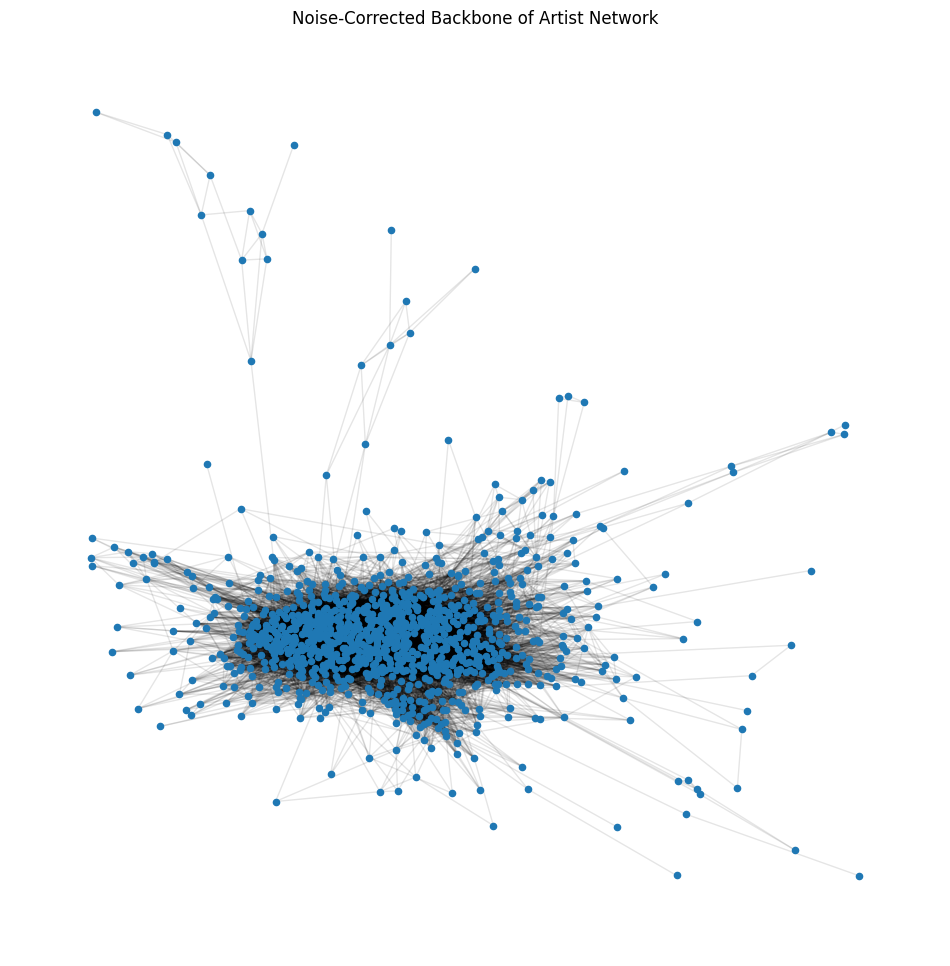

In [7]:
# plot backbone
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(NC_backbone, k=0.1)  # positions for all nodes
nx.draw_networkx_nodes(NC_backbone, pos, node_size=20)
nx.draw_networkx_edges(NC_backbone, pos, alpha=0.1)
plt.title("Noise-Corrected Backbone of Artist Network")
plt.axis('off')
plt.show()

We can now save the backbone to a .graphml file, and this can be loaded from GitHub.

```Python
# save backbone to file
nx.write_graphml(NC_backbone, "/Users/iben/Desktop/Social_graphs/SocialGraphs/Project/MUSIC/artist_network_NCbackbone_3.graphml")


In [8]:
#  Loading the NC backbone graph from Github
url = r"https://raw.githubusercontent.com/noanorgaard/SocialGraphs/refs/heads/main/Project/artist_network_NCbackbone_3.graphml" # Loading graph from a GraphML file from a URL
data = requests.get(url).text  
G_backbone = nx.parse_graphml(data)

The backbone has 1004 nodes and 16333 edges. 
We look at the top 10 artist by degree and top 10 edges by weight, to see if anything major changed. 

In [9]:
# top 10 artists by degree in NC backbone
print("Top 10 artists by degree in NC backbone:")
degree_dict = dict(G_backbone.degree())
top_10_artists = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_artists, "\n")

print("Top 10 weighted edges in NC backbone:")
# top 10 weighted edges in NC backbone
weighted_edges = nx.get_edge_attributes(G_backbone, 'nij')
top_10_weighted_edges = sorted(weighted_edges.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_weighted_edges, "\n")

print("Top 10 artists by degree in original graph:")
# top 10 artisits by degree in original graph
degree_dict_original = dict(G_lyrics.degree())
top_10_artists_original = sorted(degree_dict_original.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_artists_original, "\n")

print("Top 10 weighted edges in original graph:")
# top 10 weighted edges in original graph
weighted_edges_original = nx.get_edge_attributes(G_lyrics, 'weight')
top_10_weighted_edges_original = sorted(weighted_edges_original.items(), key=lambda x: x[1], reverse=True)[:10]
print(top_10_weighted_edges_original, "\n")

Top 10 artists by degree in NC backbone:
[('Yeah_Yeah_Yeahs', 92), ('David_Bowie', 83), ('Billy_Joel', 81), ('Lana_Del_Rey', 80), ('A_R_I_Z_O_N_A', 79), ('Aerosmith', 79), ('Coldplay', 78), ('The_Shins', 78), ('The_xx', 77), ('Eagles', 77)] 

Top 10 weighted edges in NC backbone:
[(('Drake', 'The_Weeknd'), 47), (('Drake', 'Kanye_West'), 45), (('Rihanna', 'The_Weeknd'), 35), (('Drake', 'Kendrick_Lamar'), 34), (('Drake', 'Future'), 31), (('Rae_Sremmurd', 'Big_Sean'), 30), (('Drake', 'Rae_Sremmurd'), 29), (('Rihanna', 'Chris_Brown'), 28), (('Chris_Brown', 'Drake'), 28), (('Major_Lazer', 'The_Chainsmokers'), 28)] 

Top 10 artists by degree in original graph:
[('Rihanna', 587), ('The_Weeknd', 537), ('Ed_Sheeran', 531), ('Drake', 531), ('Coldplay', 511), ('Maroon_5', 502), ('Kanye_West', 493), ('Imagine_Dragons', 482), ('Calvin_Harris', 468), ('Ariana_Grande', 449)] 

Top 10 weighted edges in original graph:
[(('Drake', 'The_Weeknd'), 47), (('Drake', 'Kanye_West'), 45), (('Rihanna', 'Drake')

As we expected, many of the edges of the popular bands has been removed. The edges of highest weight has been preserved, as they are all highly significant. Important to note, the top artists by degree have change. This means that the top artists in the original graph have many unsignificant edges. The backbone reduces the influence of hubs, which is important for fairer community detection and interpretability. 
Some mid-tier artists (e.g., Yeah_Yeah_Yeahs) gain relative importance compared to global superstars.

Below we plot the degree dist. and the weight distribution of the original graph and the NC backbone. 

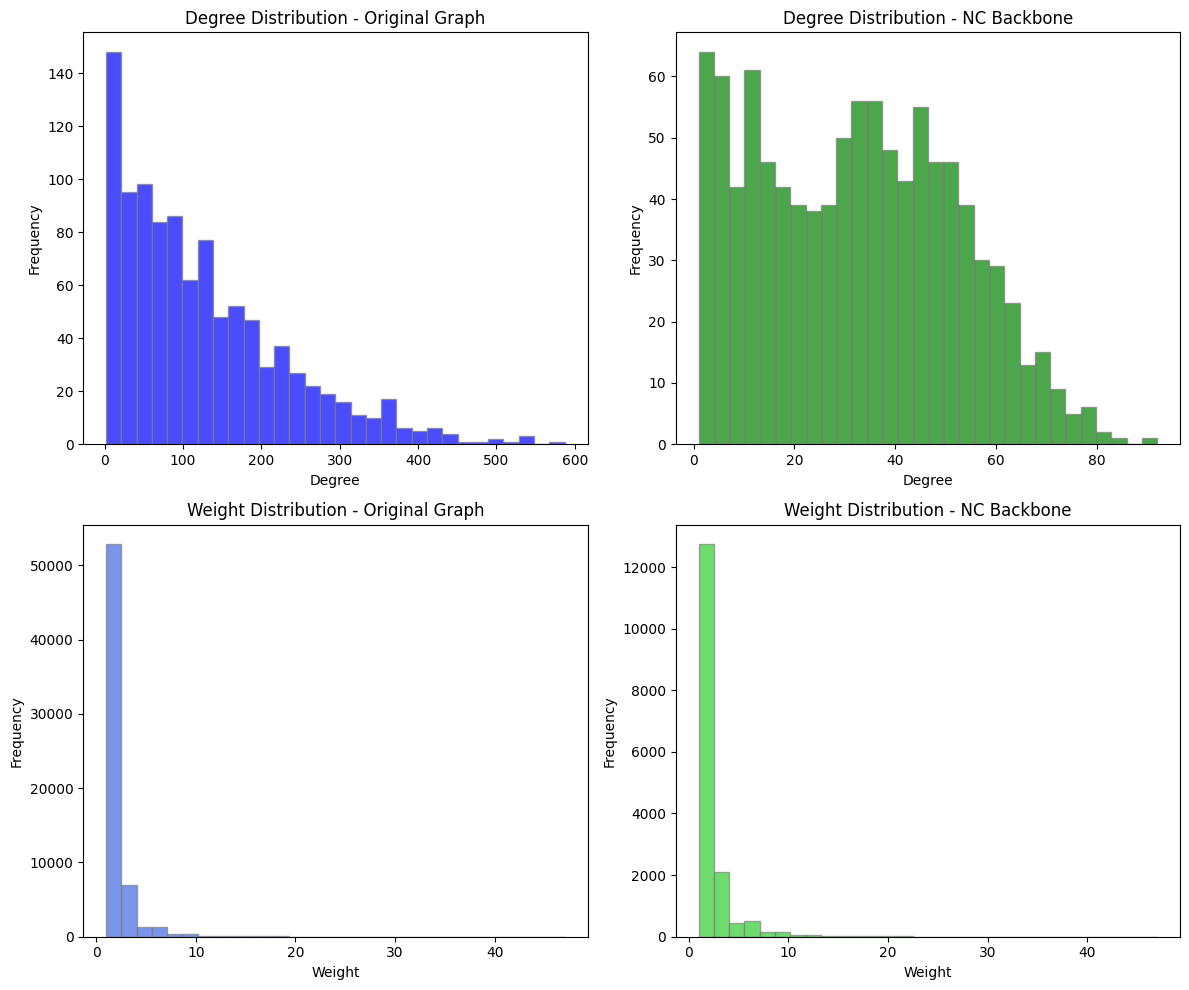

In [10]:
# Degree distribution of original graph vs NC backbone vs DF backbone in one figure with 3 subplots
def plot_degree_distributions(G_original, G_NC_backbone_3, weight_attr="weight"):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Original graph
    degrees_original = [d for n, d in G_original.degree()]
    axes[0, 0].hist(degrees_original, bins=30, color='blue', alpha=0.7, edgecolor='grey')
    axes[0, 0].set_title('Degree Distribution - Original Graph')
    axes[0, 0].set_xlabel('Degree')
    axes[0, 0].set_ylabel('Frequency')

    # NC Backbone
    degrees_nc = [d for n, d in G_NC_backbone_3.degree()]
    axes[0, 1].hist(degrees_nc, bins=30, color='green', alpha=0.7, edgecolor='grey')
    axes[0, 1].set_title('Degree Distribution - NC Backbone')
    axes[0, 1].set_xlabel('Degree')
    axes[0, 1].set_ylabel('Frequency')

    # Original graph edge weight distribution
    weights_original = [data.get(weight_attr, 1.0) for u, v, data in G_original.edges(data=True)]
    axes[1, 0].hist(weights_original, bins=30, color='royalblue', alpha=0.7, edgecolor='gray')
    axes[1, 0].set_title('Weight Distribution - Original Graph')
    axes[1, 0].set_xlabel('Weight')
    axes[1, 0].set_ylabel('Frequency')

    # NC Backbone edge weight distribution
    weights_nc = [data.get('nij', 1.0) for u, v, data in G_NC_backbone_3.edges(data=True)]
    axes[1, 1].hist(weights_nc, bins=30, color='limegreen', alpha=0.7, edgecolor='gray')
    axes[1, 1].set_title('Weight Distribution - NC Backbone')
    axes[1, 1].set_xlabel('Weight')
    axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_degree_distributions(G_lyrics, G_backbone)

Left plot, the original graph degree distribution:
Degree distribution is highly skewed. Most nodes have low degree (0–50), but a few nodes reach very high degrees (up to ~600). This indicates a dense network with hubs, i.e. some artists appear on many playlists with many others. Visualization and analysis on such a dense graph can be noisy and dominated by these hubs, which supports why we made a backbone.

Right plot, the NC backbone degree distribution:
Degree range is much smaller. Most nodes now have degrees between 0–80, with no extreme hubs.
Distribution is more balanced, instead of a sharp peak at very low degrees, there’s a broader spread (10–50 degrees common). This suggests the backbone removed weak edges, leaving only statistically significant co-occurrences. The network is now sparser and more interpretable, while still preserving connectivity for many nodes.

The backbone reduces complexity and hub dominance, making the network more suitable for tasks like community detection or visualization. It also likely improves interpretability by focusing on strong artist relationships rather than incidental co-occurrences.

A feature of the NC backbone, is that it preserves the weight distribution of the netwrok.[2]
In the plot above, this is clearly evident. By preserving the underlying weight distribution, the NC backbone helps highlight the true, underlying properties of the original network. 

[2] https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0316141

The assortativity of the graph and backbone is calculated.

In [11]:
# assortativity of original graph vs NC backbone
print(f"Assortativity of Original Graph: {nx.degree_assortativity_coefficient(G_lyrics)}")
print(f"Assortativity of NC Backbone: {nx.degree_assortativity_coefficient(G_backbone)}")

Assortativity of Original Graph: 0.0016330127467191564
Assortativity of NC Backbone: 0.08630496775567546


The original network is almost neutral in assortativity. This means high-degree nodes (hubs) connect indiscriminately to both high and low dgree nodes. This is likely caused by the dense connectivity and the many weak edges, which dilute the networks structural patterns.

The backbone has a positive assortativity, which introduces a tendency for nodes to connect to others with similar degree. This suggests that after filtering, the network becomes more structured, with clusters of similarly connected nodes.
Removing noisy edges reduces hub dominance and reveals underlying community-like patterns.

# Adding similarityscore and embedding to graph

---

## Lyrical embedding


The code below loads a pretrained sentence-transformer language model (all-MiniLM-L6-v2), which has the ability to encode text into  a 384-dimensional embedding vector. This vector represents the semantics of an artist lyrics, in numerical format. For every artist in our network we compute this embedding vector and append it to the graph as an attribute, allowing us to analysis similarity in artist semantics numerically. 

```Python

import networkx as nx
from pathlib import Path
import torch
from sentence_transformers import SentenceTransformer
import numpy as np
import json 

url = r"https://raw.githubusercontent.com/noanorgaard/SocialGraphs/refs/heads/main/Project/G_mother.graphml" # Loading graph from a GraphML file from a URL
data = requests.get(url).text  
G = nx.parse_graphml(data)
print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# helper to get device
def get_device():
    if torch.cuda.is_available(): return "cuda" # if a GPU is available
    if torch.backends.mps.is_available(): return "mps" # for Apple Silicon
    return "cpu"

device = get_device() 
print(f"Running on: {device}")

# load transformer model that converts sentences to vectors
print("Loading sentence transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2', device=device) # small, fast, good performance


node_ids = [] # index of nodes to embed
lyrics_list = [] # corresponding lyrics

print("Gathering lyrics...")
for node in G.nodes(): # loop over all nodes
    # Fetch lyrics
    raw_text = str(G.nodes[node].get('lyrics', ''))
    
    # Filter valid lyrics
    if len(raw_text) > 5: # only embed if there are lyrics
        node_ids.append(node) # store node id
        lyrics_list.append(raw_text[:2000]) # append lyrics (limit to first 2000 characters to save memory/time)

print(f"Nodes to embed: {len(node_ids)}")

# ENCODE & STORE IN GRAPH ---
if len(node_ids) > 0: # only proceed if there are lyrics to embed

    embeddings = model.encode(lyrics_list, show_progress_bar=True, device=device) # get embeddings
    
    print("Attaching vectors to nodes...")
    count = 0 # counter for nodes with embeddings
    for node, emb in zip(node_ids, embeddings): # loop over nodes and their embeddings

        G.nodes[node]['lyric_vector'] = json.dumps(emb.tolist()) # store as JSON string in graph
        count += 1 # increment counter to track number of nodes updated
        
    print(f"Successfully added vectors to {count} nodes.")

    # SAVE GRAPH ---
    print(f"Saving new graph to: {output_path}")
    nx.write_graphml(G, str(output_path))
    print("Done saving graph.")

else:
    print("No lyrics found to embed.")
    

---


## Make sentiment analysis

---

The code below loads  a pretrained sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner). This was designed to analyse short informal text, and uses a sentiment lexicon, where each word is assigned a valance score. Valence in this context refers to the emotional intensity and direction of the words meaning, going from -1(negativ) to 1(postive) with 0 being neutral. 
Vader gives every word a valence score but adjust this score based on centrain rules. For example it flips the sign of the valence for a sentence if "not" is detected, and can distingiush strengths of words like "good", "very good" and "great". So even though VADER is small and fast, it makes for a decent model to analyse sentiment of lyrics. 


```Python

import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')


url = r"https://raw.githubusercontent.com/noanorgaard/SocialGraphs/refs/heads/main/Project/G_mother.graphml" # Loading graph from a GraphML file from a URL
data = requests.get(url).text  
G = nx.parse_graphml(data)
print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


def get_nuanced_sentiment(text):
    """ A function that calculates sentiment by averaging line-by-line scores.
        This captures nuance better than a single score for the whole text.
        """
    if len(text) < 5:  # if text is too short, return neutral
        return 0.0
    
    # Split into lines
    lines = text.split('\n') # split by newline
    line_scores = [] # to hold individual line scores
    
    for line in lines: # iterate over lines
        # Skip empty lines or very short garbage
        if len(line.strip()) > 2:
            # Get the compound score for JUST this line
            score = analyzer.polarity_scores(line)['compound']
            line_scores.append(score) # store the score
            
    if not line_scores: # if no valid lines found
        return 0.0
        
    # Return the average of the lines
    return np.mean(line_scores)

# APPLY TO ALL NODES ---
print("Recalculating sentiment (Line-by-Line Average)...")
new_scores = []

for node in tqdm(G.nodes()):
    # Get raw lyrics
    lyrics = str(G.nodes[node].get('lyrics', ''))
    
    # Calculate new score
    new_score = get_nuanced_sentiment(lyrics)
    
    # Update the node attribute
    G.nodes[node]['sentiment_compound'] = float(new_score)
    new_scores.append(new_score)

# CHECK THE NEW DISTRIBUTION ---
plt.figure(figsize=(10, 5))
plt.hist(new_scores, bins=50, color='mediumseagreen', edgecolor='black')
plt.title("New Distribution: Line-by-Line Average\n(Should look like a Bell Curve)")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()

# 
output_path = G_path.parent / "artist_network_nuanced_sentiment.graphml"
nx.write_graphml(G, str(output_path))
print(f"Saved to {output_path}")



---

## Partition analysis


---


The following code compares three different ways of grouping artist in the network together. 

1. Based on network structure throught the Louvain aglorithm 

2. Based on lyric semantics, using K-means clustering

3. Based on sentiment, through binning

The goal is to see what type of grouping explains the structure of the network by comparing modularity scores.




In [12]:
import networkx as nx
import json
import numpy as np
from sklearn.cluster import KMeans
from community import community_louvain
import pandas as pd
from pathlib import Path
import requests
import re

url = r"https://raw.githubusercontent.com/noanorgaard/SocialGraphs/refs/heads/main/Project/G_mother.graphml" # Loading graph from a GraphML file from a URL
data = requests.get(url).text  
G = nx.parse_graphml(data)
print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")



# same parser that we used before for embeddings
def parse_vec(attr):
    try:
        return np.array(json.loads(attr))
    except:
        return None


# detect communities based on structural features using Louvain
struct_partition = community_louvain.best_partition(G, weight="weight") # creatre structural partition
mod_structure = community_louvain.modularity(struct_partition, G, weight="weight") # compute modularity
num_struct_coms = len(set(struct_partition.values())) # number of structural communities


# detect communities based on lyrical embeddings using K-means
embedding_dict = {} # to hold node embeddings
for node in G.nodes(): # loop over all nodes
    vec_str = G.nodes[node].get("lyric_vector") # get the JSON string
    if vec_str: # if it exists
        vec = parse_vec(vec_str) # parse to numpy array
        if vec is not None: # if parsing was successful
            embedding_dict[node] = vec # store in dictionary

# Stack vectors for K-means
nodes_with_vecs = list(embedding_dict.keys()) # get nodes with embeddings
X = np.vstack([embedding_dict[n] for n in nodes_with_vecs]) # stack vectors

# Use SAME number of clusters as Louvain for fairness
kmeans = KMeans(n_clusters=num_struct_coms, random_state=42, n_init=10) # initialize KMeans
labels = kmeans.fit_predict(X) # fit and predict

# create lyric_partition dictionary mapping nodes to their cluster labels
lyric_partition = {node: int(label) for node, label in zip(nodes_with_vecs, labels)} # create partition dictionary



# Compute modularity on subgraph (embedding nodes only)
G_sub = G.subgraph(nodes_with_vecs) # create subgraph with nodes that have embeddings
mod_lyrics = community_louvain.modularity(lyric_partition, G_sub, weight="weight") # compute modularity


# detect communities based on sentiment using quantile binning
sent_values = {node: float(G.nodes[node].get("sentiment_compound", 0)) for node in G.nodes()} # get sentiment scores
scores = pd.Series(sent_values) # convert to pandas Series

# 5 sentiment bins (20% each)
sent_bins = pd.qcut(scores, q=5, labels=[0,1,2,3,4]) # quantile binning
sent_partition = sent_bins.to_dict() # convert to dictionary

mod_sentiment = community_louvain.modularity(sent_partition, G, weight="weight") # compute modularity


print("\n=== FINAL MODULARITY SCORES ===")
print(f"Structural (Louvain):     {mod_structure:.4f}")
print(f"Lyrical (K-means):        {mod_lyrics:.4f}")
print(f"Sentiment (Quantiles):    {mod_sentiment:.4f}")


Graph loaded with 1004 nodes and 16333 edges.

=== FINAL MODULARITY SCORES ===
Structural (Louvain):     0.4968
Lyrical (K-means):        0.0885
Sentiment (Quantiles):    0.0736


# TF-IDF setup
In the following we create functions to be able to generate TF lists and IDF word counts of the tokens/words of the artist lyrics.

- We have filtered out words that appear less than 5 times, and all punctuation. 
- We have also made all characters lower case. 
- We also remove some stop words
- We normalize TF by the total tokens per partition.

In [13]:
# Compute IDF
import math
def compute_idf(df, N, method="smooth"):
    if method == "standard":
        return math.log10(N / df)
    elif method == "smooth":
        return math.log10(N / (1 + df)) + 1
    elif method == "prob":
        return math.log10((N - df) / df)

Because we are dealing with text that has a lot of spoken words and sounds, we create an extensive list of stop words, that will not be meaningfull in a sentiment analysis.

In [14]:
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
# Creating TF-IDF analysis

lemmatizer = WordNetLemmatizer()
stopwords = set(ENGLISH_STOP_WORDS)

# remove sound words like 'oh', 'la', 'na', 'yeah', 'ooh'
sound_words = {'oh', 'la', 'na', 'yeah', 'ooh', 'uh', 'ta', 'ah', 'hoo', 'ha', 'mm', 
               'hmm', 'da', 'wo', 'woah', 'whoa', 'hey', 'ay', 'ayyy', 'woo', 'woohoo',
               'ra-ta-ta-ta-ta-ta-ta-ta-ta-ta', 'dum', 'dum-dum', 'la-la-la', 'na-na-na', 'laa', 'laaa',
               'naaa', 'naaaa', 'yeaaah', 'yeaah', 'yeaaaah', 'ooh-ooh', 'uh-huh', 'mm-hmm',
               'ba-bum-bum-bum-bum', 'bom', 'bom-bom', 'da-da-da', 'da-da', 'duh', 'duh-duh', 'la-la',
               'na-na', 'na-na-na-na', 'whoa-oh', 'whoa-oh-oh', 'woo-woo', 'woo-woo-woo', 'yah', 'yahh',
               'ba-bum-bum-bum-bum', 'ba-bum-bum-bum-bum-bum', 'oh-oh', 'oh-oh-oh', 'uh-oh', 'uh-oh-oh','ooh-ooh-ooh',
               'woo-hoo','m-m-m-m-m', 'oh-nah-nah-nah','mmm-mm-hmm-mm', 'mm-mm-hmm', 'hmmm-mm'}
uninteresting_words = {"i'm", "im", "ive", "i've", "youre", "you're","we're", "were", "hes", "he's", "it's", "its",
                       "shes", "she's", "thats", "that's", "whats", "what's", "couldnt", "i'll", "ill", "youll", "you'll",
                       "he'll", "she'll", "we'll", "well", "they'll", "theyll", "isnt", "isn't", "wasnt", "wasn't",
                       "werent", "weren't", "dont", "don't", "doesnt", "doesn't", "wont", "won't", "let's", "lets",
                       "shouldnt", "shouldn't", "mightnt", "mightn't", "mustnt", "mustn't", "hadnt", "hadn't","let",
                       "couldn't", "wouldnt", "wouldn't", "didnt", "didn't", "got", "gonna","there's"}
stopwords.update(sound_words)
stopwords.update(uninteresting_words)


In [15]:
def compute_tf_tfidf_by_partition(G, partition, stopwords, lemmatizer, min_word_count=5, top_k_per_cluster=200):
    """
    Compute TF and TF-IDF for each cluster in a partition.
    
    Args:
        G: NetworkX graph with 'lyrics' attribute on nodes
        partition: dict mapping node -> cluster_id
        stopwords: set of words to exclude
        lemmatizer: lemmatizer object with lemmatize method
        min_word_count: minimum word count threshold per cluster
        top_k_per_cluster: number of top TF-IDF words to return per cluster
    
    Returns:
        TF_lists_by_cluster: dict {cluster_id: [(word, count), ...]}
        TFIDF_lists_by_cluster: dict {cluster_id: [(word, tfidf_score), ...]}
    """
    cluster_counts = defaultdict(Counter)
    cluster_token_totals = defaultdict(int)

    for node, data in G.nodes(data=True):
        if node not in partition:
            continue
        lyrics = str(data.get('lyrics', ''))
        if len(lyrics) < 50:
            continue

        # tokenize + normalize + lemmatize
        lyrics = lyrics.replace("'", "'").lower()
        tokens = re.findall(r"\b[a-z']{2,}\b", lyrics)
        lemmas = [lemmatizer.lemmatize(t) for t in tokens if t not in stopwords]

        # update cluster counters
        cid = int(partition[node])
        cluster_counts[cid].update(lemmas)
        cluster_token_totals[cid] += len(lemmas)

    # Filter infrequent words and compute IDF
    cluster_TF = {}
    IDF_counts_cluster = Counter()
    for cid, counter in cluster_counts.items():
        filtered = Counter({w: c for w, c in counter.items() if c >= min_word_count})
        cluster_TF[cid] = filtered
        for w in filtered:
            IDF_counts_cluster[w] += 1

    num_cluster_docs = len(cluster_TF)

    # Compute TF-IDF per cluster
    cluster_TFIDF = {}
    for cid, counter in cluster_TF.items():
        total = sum(counter.values()) or 1
        tfidf = {}
        for w, cnt in counter.items():
            tf = cnt / total
            df = IDF_counts_cluster.get(w, 0)
            idf = compute_idf(df, num_cluster_docs, method="smooth")
            tfidf[w] = tf * idf
        cluster_TFIDF[cid] = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)[:top_k_per_cluster]

    TF_lists_by_cluster = {cid: list(counter.items()) for cid, counter in cluster_TF.items()}
    TFIDF_lists_by_cluster = cluster_TFIDF

    return TF_lists_by_cluster, TFIDF_lists_by_cluster

We will also need a function that can plot our wordclouds

In [16]:
from wordcloud import WordCloud

def plot_tf_vs_tfidf(TF_lists_by_cluster, TFIDF_lists_by_cluster, clusters=None, NUM_WORDS=50, n=6,
                     tf_title="TF (raw counts)", tfidf_title="TF-IDF (top terms)",
                     wc_kwargs=None, figsize_per_row=(12,3),
                     plot_tf=True, plot_tfidf=True,
                     show_cluster_label=True, custom_titles=None):
    """
    Plot TF vs TF-IDF wordclouds for clusters.
      - TF_lists_by_cluster: {cid: [(word,count), ...], ...}
      - TFIDF_lists_by_cluster: {cid: [(word,score), ...], ...}
      - clusters: optional list of cluster ids to plot (ordered). If None, choose top-n by TF size.
      - n: number of clusters to plot
      - plot_tf / plot_tfidf: booleans to control which column(s) to draw
      - show_cluster_label: if True, prefix title with "Cluster X —"; if False, use custom_titles
      - custom_titles: dict {cid: "custom title"} or list of titles (one per cluster)
    """
    wc_kwargs = wc_kwargs or {"background_color":"white", "width":600, "height":400}
    # choose clusters if not provided
    if clusters is None:
        # rank clusters by total TF tokens (fallback to len of TF list)
        ranking = sorted(TF_lists_by_cluster.keys(),
                         key=lambda c: sum(count for _, count in TF_lists_by_cluster.get(c, [])),
                         reverse=True)
        clusters = ranking[:n]
    else:
        clusters = list(clusters)[:n]

    rows = len(clusters)
    cols = int(bool(plot_tf)) + int(bool(plot_tfidf))

    if rows == 0 or cols == 0:
        print("No clusters or no plot columns selected.")
        return

    fig, axes = plt.subplots(rows, cols, figsize=(figsize_per_row[0], figsize_per_row[1]*rows))
    # normalize axes to 2D array for consistent indexing
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = np.array([axes]).reshape(1, cols)
    elif cols == 1:
        axes = np.array(axes).reshape(rows, 1)

    for i, cid in enumerate(clusters):
        col_idx = 0
        # TF frequencies dict
        tf_pairs = TF_lists_by_cluster.get(cid, [])
        tf_freq = {w: c for w, c in tf_pairs}
        # TF-IDF dict (use scores directly)
        tfidf_pairs = TFIDF_lists_by_cluster.get(cid, [])
        tfidf_freq = {w: score for w, score in tfidf_pairs}

        # Determine custom title for this cluster
        if custom_titles is not None:
            if isinstance(custom_titles, dict):
                custom_title = custom_titles.get(cid, "")
            elif isinstance(custom_titles, list) and i < len(custom_titles):
                custom_title = custom_titles[i]
            else:
                custom_title = ""
        else:
            custom_title = ""

        if plot_tf:
            ax = axes[i, col_idx]
            if tf_freq:
                wc_tf = WordCloud(**wc_kwargs, max_words=NUM_WORDS).generate_from_frequencies(tf_freq)
                ax.imshow(wc_tf, interpolation='bilinear')
                if show_cluster_label:
                    ax.set_title(f"Cluster {cid} — {tf_title}")
                else:
                    ax.set_title(custom_title if custom_title else tf_title)
            else:
                ax.text(0.5,0.5,"No TF data", ha='center', va='center')
            ax.axis('off')
            col_idx += 1

        if plot_tfidf:
            ax = axes[i, col_idx]
            if tfidf_freq:
                max_score = max(tfidf_freq.values()) or 1.0
                scaled = {w: (s/max_score) for w,s in tfidf_freq.items()}
                wc_tfidf = WordCloud(**wc_kwargs, max_words=NUM_WORDS).generate_from_frequencies(scaled)
                ax.imshow(wc_tfidf, interpolation='bilinear')
                if show_cluster_label:
                    ax.set_title(f"Cluster {cid} — {tfidf_title}")
                else:
                    ax.set_title(custom_title if custom_title else tfidf_title)
            else:
                ax.text(0.5,0.5,"No TF-IDF data", ha='center', va='center')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# TF-IDF on lyrical similar partitioning

In [17]:
# calculate mean value of sentiment of each label, using all nodes within the label (given the lyric_partition)
cluster_sentiments = {}
cluster_sizes = {}

for node in G.nodes():
    sentiment = G.nodes[node].get('sentiment_compound')
    cluster_id = G.nodes[node].get('lyric_community')
    if sentiment is not None and cluster_id is not None:
        cluster_sentiments.setdefault(cluster_id, 0)
        cluster_sizes.setdefault(cluster_id, 0)
        cluster_sentiments[cluster_id] += float(sentiment)
        cluster_sizes[cluster_id] += 1
# Calculate average sentiment for each cluster
for cid in cluster_sentiments:
    cluster_sentiments[cid] /= cluster_sizes[cid]

# print with lowest sentiment first
for cid, avg_sentiment in sorted(cluster_sentiments.items(), key=lambda x: x[1]):
    print(f"Cluster {cid}: Average Sentiment = {avg_sentiment:.4f}")

Cluster 4: Average Sentiment = -0.3952
Cluster 7: Average Sentiment = -0.1840
Cluster 6: Average Sentiment = 0.3950
Cluster 3: Average Sentiment = 0.5728
Cluster 5: Average Sentiment = 0.6072
Cluster 8: Average Sentiment = 0.6247
Cluster 1: Average Sentiment = 0.6339
Cluster 2: Average Sentiment = 0.7269
Cluster 0: Average Sentiment = 0.9060


We expect cluster 4 to have more sad words, cluster 6 to be more average or without sentiment, and cluster 0 to be more happy.

In [18]:
# reuse notebook parameters if present, else set defaults
min_word_count = globals().get("min_word_count", 5)
top_k_per_cluster = globals().get("top_k_per_cluster", 200)
lemmatizer = globals().get("lemmatizer", None)
stopwords = globals().get("stopwords", None)

# ensure lemmatizer/stopwords available
if lemmatizer is None:
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
if stopwords is None:
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    stopwords = set(ENGLISH_STOP_WORDS)

In [19]:
# calculate TF and TD_IDF lists for all lyrical-similarity (embedding) communities
TF_lists_by_lyric, TFIDF_lists_by_lyric = compute_tf_tfidf_by_partition(
    G,
    partition={n: G.nodes[n].get('lyric_community') for n in G.nodes()},
    stopwords=stopwords,
    lemmatizer=lemmatizer,
    min_word_count=min_word_count,
    top_k_per_cluster=top_k_per_cluster
)

Now we can plot the wordclouds for the three clusters

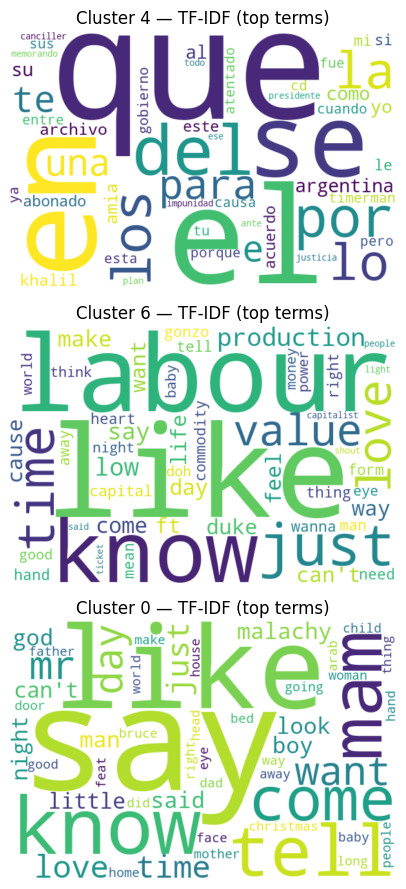

In [20]:
# plot TF-IDF for louvain communities [4,6,0]
plot_tf_vs_tfidf(
    TF_lists_by_lyric,
    TFIDF_lists_by_lyric,
    clusters=[4,6,0],
    NUM_WORDS=50,
    n=3,
    tf_title="TF (raw counts)",
    tfidf_title="TF-IDF (top terms)",
    wc_kwargs={"background_color":"white", "width":600, "height":400},
    figsize_per_row=(12,3),
    plot_tf=False,
    plot_tfidf=True,
    show_cluster_label=True
)

# TF-IDF on Louvain clusters


In [21]:
# extracting louvain communities from attributes on nodes in the graph G to calculate the sentiment inside each of the communities

# calculate mean value of sentiment of each louvain_label, using all nodes within the label
cluster_lou_sentiments = {}
cluster_lou_sizes = {}

for node in G.nodes():
    sentiment = G.nodes[node].get('sentiment_compound')
    louvain_id = G.nodes[node].get('louvain_community')
    if sentiment is not None and louvain_id is not None:
        cluster_lou_sentiments.setdefault(louvain_id, 0)
        cluster_lou_sizes.setdefault(louvain_id, 0)
        cluster_lou_sentiments[louvain_id] += float(sentiment)
        cluster_lou_sizes[louvain_id] += 1
# Calculate average sentiment for each louvain cluster
for cid in cluster_lou_sentiments:
    cluster_lou_sentiments[cid] /= cluster_lou_sizes[cid]

# print with lowest sentiment first
for cid, avg_lou_sentiment in sorted(cluster_lou_sentiments.items(), key=lambda x: x[1]):
    print(f"Cluster {cid}: Average Sentiment = {avg_lou_sentiment:.4f}")

Cluster 1: Average Sentiment = -0.3261
Cluster 0: Average Sentiment = -0.1798
Cluster 4: Average Sentiment = 0.4630
Cluster 6: Average Sentiment = 0.6029
Cluster 8: Average Sentiment = 0.6201
Cluster 3: Average Sentiment = 0.6899
Cluster 5: Average Sentiment = 0.7966
Cluster 7: Average Sentiment = 0.8403
Cluster 2: Average Sentiment = 0.8995


The louvain communities derived from the co-occurence network seems to have distinct sentiment profiles. A few clusters (0 and 1) are havily negative, suggesting that artist appear together in these clusters share darker themes. The remaining communities has increasingly positive averages. Morover the distribution is not centred around zero but polarized. This could be because music lyrics often convey emotions(positive and negative), and neutral songs are quite rare. It could also be an effect of the way the sentiment score was calculated using VADER and another method could produce more zero centered results.

It would now be interesting to look at the TF-IDF words of the clusters with most negative and most positive average sentiment, and see if we can see a difference in the use of words.

In [22]:
# reuse notebook parameters if present, else set defaults
min_word_count = globals().get("min_word_count", 5)
top_k_per_cluster = globals().get("top_k_per_cluster", 200)
lemmatizer = globals().get("lemmatizer", None)
stopwords = globals().get("stopwords", None)

# ensure lemmatizer/stopwords available
if lemmatizer is None:
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
if stopwords is None:
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    stopwords = set(ENGLISH_STOP_WORDS)

In [23]:
# calculate TF and TD_IDF lists for all louvain communities
TF_lists_by_louvain, TFIDF_lists_by_louvain = compute_tf_tfidf_by_partition(
    G,
    partition={n: G.nodes[n].get('louvain_community') for n in G.nodes()},
    stopwords=stopwords,
    lemmatizer=lemmatizer,
    min_word_count=min_word_count,
    top_k_per_cluster=top_k_per_cluster
)


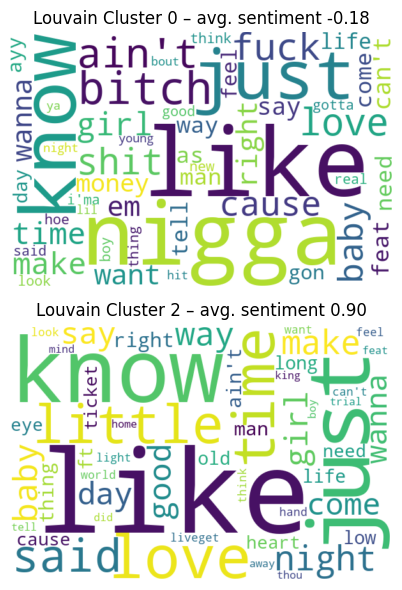

In [24]:
import matplotlib.pyplot as plt
# plot TF-IDF for louvain communities [1,4,2]
plot_tf_vs_tfidf(
    TF_lists_by_louvain,
    TFIDF_lists_by_louvain,
    clusters=[0,2],
    NUM_WORDS=50,
    n=3,
    tf_title="TF (raw counts)",
    tfidf_title="TF-IDF (top terms)",
    wc_kwargs={"background_color":"white", "width":600, "height":400},
    figsize_per_row=(12,3),
    plot_tf=False,
    plot_tfidf=True,
    show_cluster_label=False,
    custom_titles={0: f"Louvain Cluster 0 – avg. sentiment {cluster_lou_sentiments.get(0, 'N/A'):.2f}", 2: f"Louvain Cluster 2 – avg. sentiment {cluster_lou_sentiments.get(2, 'N/A'):.2f}"}
)


We see that cluster 1 is grouped mainly because they are spanish artists, but we used VADER which is designed for English text and relies on an English lexicon, so the sentiment analysis of those artist should not be consider for analysis.
Cluster 4: contained a more neutral vocabulary centred on everyday verbs such as “say,” “know,” and “want,” aligning with a moderate positive sentiment profile.
Cluster 2: was characterised by a distinctly affectionate  terms “love,” “baby,” “good,” and “time,” a clear romantic and celebratory tone.

# Cliques

In a graph Cliques is a tighly connected subgraph, where every artist is connected to every artist in the clique, making it a maximally dense subgraph. This means for put co-occurence graph, that cliques indicate the most consistently co-curated groups of artists, i.e cliques are groups of artist almost always placed on a playlist together. Analyzing these could reveal smaller scale groupings then the commounity approach.  


Now we can find all the cliques in the graph

In [25]:
# find all cliques
cliques = list(nx.find_cliques(G))
print(f"Number of cliques in the graph: {len(cliques)}")


Number of cliques in the graph: 16931


It is now possible to start our analysis on the cliques. We will firstly investigate the structure of the cliques.

In [26]:

# analyze clique size distribution
clique_sizes = [len(clique) for clique in cliques]
size_counts = pd.Series(clique_sizes).value_counts().sort_index()
print("Clique size distribution:")
print(size_counts)

Clique size distribution:
2     322
3    3622
4    6204
5    4082
6    1855
7     679
8     157
9      10
Name: count, dtype: int64


Most frequent clique size is 4, with over 6,000 cliques. Clique sizes of 3 and 5 are also common, indicating moderate-sized fully connected groups. Larger cliques (sizes 7–9) are rare, suggesting that dense subgroups of many artists are uncommon. Very few cliques of size 2 (pairs).

The backbone preserves local dense structures, which are likely meaningful clusters of artists frequently co-occurring on playlists. The absence of very large cliques suggests that the backbone reduces hub-driven connectivity and focuses on cohesive subgroups rather than global hubs. Which we also saw when plotting the degree distribution of the original graph and NC backbone earlier.
This pattern supports the idea that the Noise-Corrected Backbone enhances modularity and community detection potential.

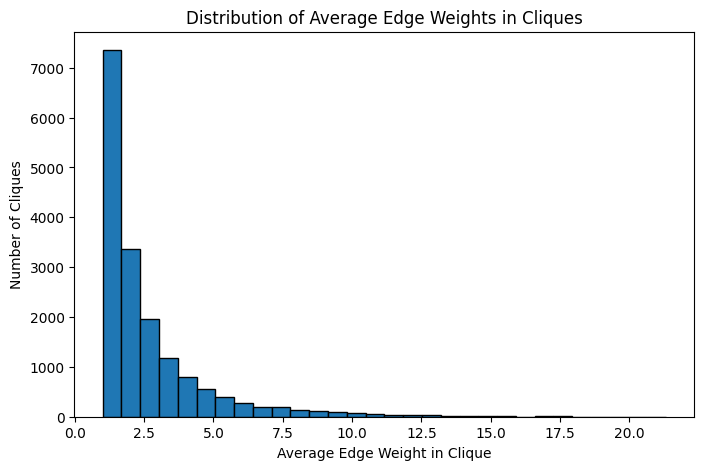

Highest average edge weight in a clique: 21.333333333333332


In [27]:
# Distribution of averge weights of edges in cliques
average_weights = []
for clique in cliques:
    edges = [(clique[i], clique[j]) for i in range(len(clique)) for j in range(i+1, len(clique))]
    edge_weights = []
    for edge in edges:
        if G.has_edge(*edge):
            edge_weights.append(G[edge[0]][edge[1]]['weight'])
    average_weight = np.mean(edge_weights)
    average_weights.append(average_weight)

plt.figure(figsize=(8, 5))
plt.hist(average_weights, bins=30, edgecolor='black')
plt.xlabel('Average Edge Weight in Clique')
plt.ylabel('Number of Cliques')
plt.title('Distribution of Average Edge Weights in Cliques')
plt.show()

print("Highest average edge weight in a clique:", max(average_weights))

The above plot shows the distribution of average edge weights in cliques found in the noise-corrected backbone.

The distribution is highly skewed toward low values. Most cliques have an average edge weight between 1.0 and 2.5, with the highest frequency around 1.5. A long tail extends up to 21.33, but very few cliques have such high average weights.

Cliques with higher average weights represent strongly interconnected artist groups (e.g., frequent co-occurrence across playlists). These heavily connected artists would be interesting for further analysis.

The dominance of low-weight cliques indicates that meaningful communities can emerge from moderate-weight ties when they are statistically significant.

## Lyrical similarity (semantics from embedding) in cliques
In the following analysis we will only be looking at cliques that range from size 4 to 9, as smaller cliques are not meningful for our analysis.

In [28]:
# remove all cliques with more less than 4 members
filtered_cliques = [clique for clique in cliques if len(clique) >= 4]
print(f"Number of cliques with size >= 4: {len(filtered_cliques)}")

Number of cliques with size >= 4: 12987


Below the average cosine similarity between all pairs of nodes in all cliques are calculated. We want to investigate, if there are lyrical similarity inside the cliques.

Overall average cosine similarity in the graph: 0.35


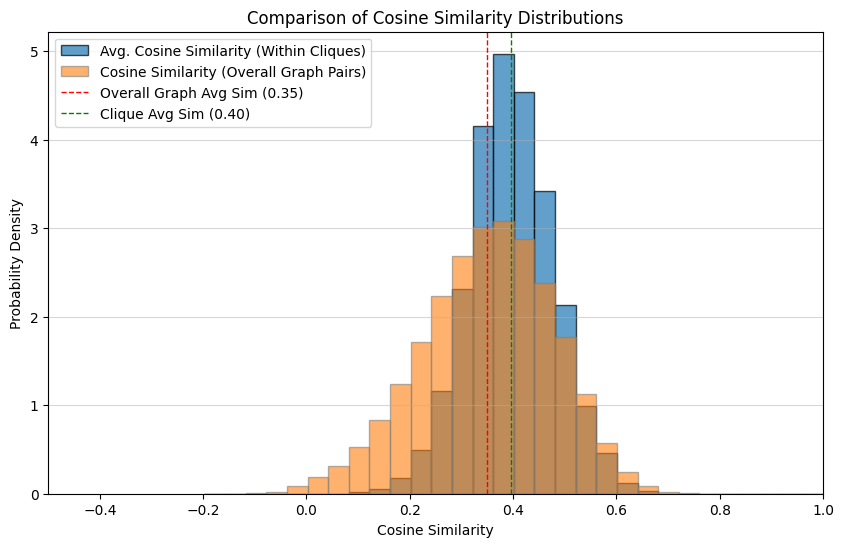

In [29]:
# Find average cosine similarity of lyric vectors within each clique
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    return dot_product / (norm1 * norm2)

# find average cosine similarity of lyric vectors within each clique
average_cosine_sims_of_cliques = []
for clique in filtered_cliques:
    vectors = []
    for node in clique:
        vector_str = G.nodes[node].get('lyric_vector')
        if vector_str:
            vector = np.array(json.loads(vector_str))
            vectors.append(vector)
    # compute pairwise cosine similarities
    sims = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            sim = cosine_similarity(vectors[i], vectors[j])
            sims.append(sim)
    # average similarity for this clique
    if sims:
        avg_sim = sum(sims) / len(sims)
        average_cosine_sims_of_cliques.append(avg_sim)


# find the cosine similarity distribution across the whole graph
all_vectors = []
for node in G.nodes():
    vector_str = G.nodes[node].get('lyric_vector')
    if vector_str:
        vector = np.array(json.loads(vector_str))
        all_vectors.append(vector)
all_sims = []
for i in range(len(all_vectors)):
    for j in range(i + 1, len(all_vectors)):
        sim = cosine_similarity(all_vectors[i], all_vectors[j])
        all_sims.append(sim)
overall_avg_sim = sum(all_sims) / len(all_sims)
print(f"Overall average cosine similarity in the graph: {overall_avg_sim:.2f}")

# plot two histograms - one of the  average cosine similarities of cliques and one for the overall graph in one figure
min_val = min(min(average_cosine_sims_of_cliques), min(all_sims)) if average_cosine_sims_of_cliques and all_sims else -1.0
max_val = max(max(average_cosine_sims_of_cliques), max(all_sims)) if average_cosine_sims_of_cliques and all_sims else 1.0

# Define a common set of bin edges.
number_of_bins = 30
common_bins = np.linspace(min_val, max_val, number_of_bins + 1)


# plot two histograms in one figure
plt.figure(figsize=(10, 6))

# Histogram 1: Average Cosine Similarities of Cliques
plt.hist(
    average_cosine_sims_of_cliques,
    bins=common_bins,  
    alpha=0.7,
    label='Avg. Cosine Similarity (Within Cliques)',
    edgecolor='black',
    density=True)

# Histogram 2: Cosine Similarity Distribution Across the Whole Graph
plt.hist(
    all_sims,
    bins=common_bins,  
    alpha=0.6,
    label='Cosine Similarity (Overall Graph Pairs)',
    edgecolor='gray',
    density=True)



# Add the overall average similarity line
plt.axvline(
    overall_avg_sim,
    color='red',
    linestyle='dashed',
    linewidth=1,
    label=f'Overall Graph Avg Sim ({overall_avg_sim:.2f})'
)
# Add the clique average similarity line
if average_cosine_sims_of_cliques:
    clique_avg_sim = sum(average_cosine_sims_of_cliques) / len(average_cosine_sims_of_cliques)
    plt.axvline(
        clique_avg_sim,
        color='green',
        linestyle='dashed',
        linewidth=1,
        label=f'Clique Avg Sim ({clique_avg_sim:.2f})'
    )

plt.xlabel('Cosine Similarity')
plt.ylabel('Probability Density')
plt.title('Comparison of Cosine Similarity Distributions')
plt.legend()
plt.xlim(-0.5, 1)
plt.grid(axis='y', alpha=0.5)
plt.show()

This histogram shows the distribution of average cosine similarity within cliques.

The distribution is roughly bell-shaped, centered around 0.36–0.4. Most cliques have moderate similarity (0.3–0.5), suggesting members share some common features but are not identical.
Very few cliques have extremely low (<0.2) or high (>0.6) similarity, meaning highly dissimilar or highly homogeneous cliques are rare.

This suggests cliques are generally cohesive but not overly homogeneous.
The peak near 0.4 indicates moderate lyrical simiilarity among artists in playlists.

The lyrical similarity within the cliques are shifted to the right of of the global similarity, meaning that we have a higher degree of similiarity in lyrics within cliques. 

Below the most similar cliques in terms of cosine similarity are printed.

In [30]:
# top 10 cliques based on cosine similarity
top_10_cliques = sorted(zip(filtered_cliques, average_cosine_sims_of_cliques), key=lambda x: x[1], reverse=True)[:10]
for i, (clique, avg_sim) in enumerate(top_10_cliques, 1):
    print(f"Clique {i}: Size={len(clique)}, Average Cosine Similarity={avg_sim:.4f}, Members={clique}")

Clique 1: Size=5, Average Cosine Similarity=0.6849, Members=['Luis_Fonsi', 'J_Balvin', 'Ozuna', 'Maluma', 'Reik']
Clique 2: Size=4, Average Cosine Similarity=0.6783, Members=['El_Fantasma', 'Alfredo_Olivas', 'Virlan_Garcia', 'Los_Plebes_del_Rancho_de_Ariel_Camacho']
Clique 3: Size=5, Average Cosine Similarity=0.6678, Members=['Maluma', 'Ozuna', 'Yandel', 'Noriel', 'J_Balvin']
Clique 4: Size=4, Average Cosine Similarity=0.6619, Members=['Makaveli', 'E-40', 'Thug_Life', '2Pac']
Clique 5: Size=4, Average Cosine Similarity=0.6588, Members=['El_Fantasma', 'Alfredo_Olivas', 'Virlan_Garcia', 'Roberto_Tapia']
Clique 6: Size=5, Average Cosine Similarity=0.6585, Members=['Pepe_Quintana', 'Yandel', 'Noriel', 'Maluma', 'J_Balvin']
Clique 7: Size=5, Average Cosine Similarity=0.6546, Members=['Big_Sean', 'Yo_Gotti', 'Tyga', 'Meek_Mill', 'Mike_Stud']
Clique 8: Size=4, Average Cosine Similarity=0.6540, Members=['Nas', 'Busta_Rhymes', 'Wu-Tang_Clan', '2Pac']
Clique 9: Size=5, Average Cosine Similarity=

In the top 10 cliques on cosine similarity, there are two dominant stylistic families. 
1. Latin urban/reggaeton 
2. Mainstream US hip‑hop. 

The average cosine similarity of biggest cliques (9-cliques)

In [37]:
# all biggest cliques and its average cosine similarity
max_clique_size = max(len(clique) for clique in filtered_cliques)
biggest_cliques = [(clique, avg_sim) for clique, avg_sim in zip(filtered_cliques, average_cosine_sims_of_cliques) if len(clique) == max_clique_size]
print(f"\nBiggest cliques (size={max_clique_size}):")
for i, (clique, avg_sim) in enumerate(biggest_cliques, 1):
    print(f"Clique {i}: Average Cosine Similarity={avg_sim:.4f}, Members={clique}")



Biggest cliques (size=9):
Clique 1: Average Cosine Similarity=0.5243, Members=['Twista', '50_Cent', 'Soulja_Boy', 'Trina', 'Trick_Daddy', 'Three_6_Mafia', 'Sean_Paul', 'Lil_Jon', 'Fat_Joe']
Clique 2: Average Cosine Similarity=0.4903, Members=['Twista', '50_Cent', 'Soulja_Boy', 'Trina', 'Trick_Daddy', 'Three_6_Mafia', 'Ludacris', 'Busta_Rhymes', 'Bubba_Sparxxx']
Clique 3: Average Cosine Similarity=0.4972, Members=['Twista', '50_Cent', 'Soulja_Boy', 'Trina', 'Trick_Daddy', 'Three_6_Mafia', 'Ludacris', 'Lil_Jon', 'Fat_Joe']
Clique 4: Average Cosine Similarity=0.4695, Members=['Twista', '2Pac', 'Bubba_Sparxxx', 'Busta_Rhymes', 'Trick_Daddy', 'Trina', 'Three_6_Mafia', 'Ludacris', 'Soulja_Boy']
Clique 5: Average Cosine Similarity=0.3839, Members=['Sylvan_Esso', 'Spoon', 'The_Kills', 'Lewis_Del_Mar', 'Kaskade', 'Atlas_Genius', 'Cloud_Nothings', 'Kaleo', 'Marian_Hill']
Clique 6: Average Cosine Similarity=0.4182, Members=['Sylvan_Esso', 'Spoon', 'The_Kills', 'Lewis_Del_Mar', 'Kaskade', 'Atlas_

In 9-cliques have cosine similarity between 0.4 and 0.52. There are three dominant stylistic families. 
1. Mid-2000s Hip-Hop / Rap
2. Indie Pop / Alternative Rock / Electronic-Indie
3. Modern Country & Country-Pop

## Average weight inside all cliques vs avg similarity inside clique

We expect cliques that have a high average weight (meaning that they are highly connected and are featured on a lot of the same playlists) to have high semantic similarity, which means that we will see a positive relationship on the graph. 

In [32]:
# average weight inside all cliques vs avg similarity inside clique
# color all dots on the graph in each their own depending on clique size
# make a trend line in red in the graph

import matplotlib.pyplot as plt
from itertools import combinations

# build L2-normalized vectors for nodes (skip missing / zero vectors)
node_vecs = {}
for n, d in G.nodes(data=True):
    s = d.get('lyric_vector')
    if not s:
        continue
    v = np.array(json.loads(s), dtype=float)
    norm = np.linalg.norm(v)
    if norm == 0:
        continue
    node_vecs[n] = v / norm

# choose cliques to analyze (use filtered_cliques if available)
cliques_to_use = globals().get("filtered_cliques", globals().get("cliques", []))

sizes = []
avg_edge_weights = []
avg_cosine_sims = []

for clique in cliques_to_use:
    # edges: average weight
    edge_weights = []
    for u, v in combinations(clique, 2):
        if G.has_edge(u, v):
            w = G[u][v].get('weight', None)
            if w is not None:
                try:
                    edge_weights.append(float(w))
                except:
                    pass
    if not edge_weights:
        continue

    # vectors: only nodes that have vectors
    vec_nodes = [n for n in clique if n in node_vecs]
    if len(vec_nodes) < 2:
        continue

    V = np.vstack([node_vecs[n] for n in vec_nodes])
    sims = V @ V.T
    iu = np.triu_indices(len(V), k=1)
    mean_sim = float(sims[iu].mean())

    sizes.append(len(clique))
    avg_edge_weights.append(float(np.mean(edge_weights)))
    avg_cosine_sims.append(mean_sim)

# convert to arrays
sizes = np.array(sizes)
avg_edge_weights = np.array(avg_edge_weights)
avg_cosine_sims = np.array(avg_cosine_sims)


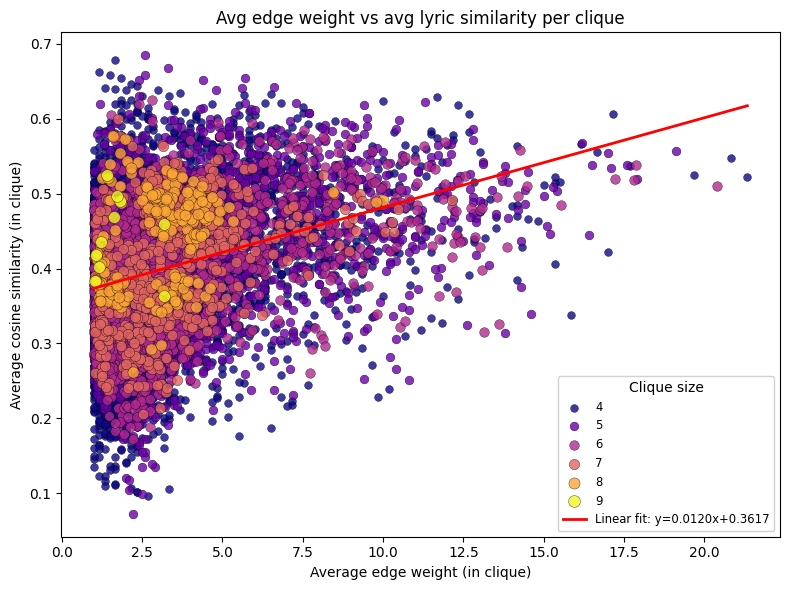

Pearson r between avg weight and avg similarity: 0.3320


In [33]:
# discrete-size labeled scatter, plot smallest-first so larger markers are on top
plt.figure(figsize=(8,6))

unique_sizes = np.unique(sizes)
unique_sizes.sort()  # ascending -> plot smallest first

cmap = plt.cm.plasma
colors = {s: cmap(i / max(1, len(unique_sizes)-1)) for i, s in enumerate(unique_sizes)}

handles = []
for s in unique_sizes:
    mask = (sizes == s)
    if not mask.any():
        continue
    sc_handle = plt.scatter(avg_edge_weights[mask],
                            avg_cosine_sims[mask],
                            c=[colors[s]],
                            s=np.clip(s, 4, 50) * 8,
                            alpha=0.8,
                            edgecolor='k',
                            linewidth=0.3,
                            label=str(int(s)),
                            zorder=int(s))  # larger sizes have higher zorder
    handles.append(sc_handle)

plt.xlabel('Average edge weight (in clique)')
plt.ylabel('Average cosine similarity (in clique)')
plt.title('Avg edge weight vs avg lyric similarity per clique')

# linear trend (fit) drawn beneath points
if len(avg_edge_weights) > 1:
    coef = np.polyfit(avg_edge_weights, avg_cosine_sims, deg=1)
    x_line = np.linspace(np.nanmin(avg_edge_weights), np.nanmax(avg_edge_weights), 200)
    y_line = np.polyval(coef, x_line)
    plt.plot(x_line, y_line, color='red', linewidth=2, zorder=int(s)+1,
             label=f'Linear fit: y={coef[0]:.4f}x+{coef[1]:.4f}')

# Legend inside plot in the southeast (lower right) corner
plt.legend(title='Clique size', loc='lower right', frameon=True, framealpha=0.9, fontsize='small')
plt.tight_layout()
plt.show()

# Pearson correlation
if len(avg_edge_weights) > 1:
    r = np.corrcoef(avg_edge_weights, avg_cosine_sims)[0,1]
    print(f"Pearson r between avg weight and avg similarity: {r:.4f}")

Every dot on the plot is a clique. The scatter plot of average clique edge weight (x-axis) versus average clique cosine similarity of lyric embeddings (y-axis) exhibits a clear positive linear relationship. The fitted line (y = 0.012x + 0.362) implies that, on average, every additional shared-playlist unit in a clique is associated with a 0.012 increase in semantic similarity, starting from a baseline cohesion around 0.36 even for weakly connected groups. 

Points are colored by clique size (4–9) and follow the same upward trend, indicating the effect holds across local densities and is not driven solely by larger cliques.

The Pearson correlation coefficient r quantifies the strength and direction of a linear association between two variables. Here, r = 0.33 indicates a positive, but moderate relationship: cliques with higher average co-occurrence weight tend to have higher average lyric semantic similarity. The trend is consistent across clique sizes (4–9), suggesting the effect is not driven by clique size alone.

## Sentiment inside cliques

We want to investigate if there are any similarity in sentiment score for the aritists in the cliques. Below the mean sentiment and standard deviation is calculated for each clique. The top 5 most positive and top 5 most negative cliques are printed. 

In [41]:
# Top 5 cliques by sentiment score mean
top_5_mean_cliques = sorted(filtered_cliques, key=lambda x: np.mean([G.nodes[node].get('sentiment_compound') for node in x]), reverse=True)[:5]
print("Top 5 cliques by sentiment score mean:")
for clique in top_5_mean_cliques:
    mean = np.mean([G.nodes[node].get('sentiment_compound') for node in clique])
    std = np.std([G.nodes[node].get('sentiment_compound') for node in clique])
    print(f"Clique size: {len(clique)}, Mean sentiment: {mean}, Standard deviation: {std}")
    print(clique)
print("\n")

# bottom 5 cliques by sentiment score mean
bottom_5_mean_cliques = sorted(filtered_cliques, key=lambda x: np.mean([G.nodes[node].get('sentiment_compound') for node in x]))[:5]
print("Bottom 5 cliques by sentiment score mean:")
for clique in bottom_5_mean_cliques:
    mean = np.mean([G.nodes[node].get('sentiment_compound') for node in clique])
    std = np.std([G.nodes[node].get('sentiment_compound') for node in clique])
    print(f"Clique size: {len(clique)}, Mean sentiment: {mean}, Standard deviation: {std}")
    print(clique)


Top 5 cliques by sentiment score mean:
Clique size: 4, Mean sentiment: 1.0, Standard deviation: 0.0
['Lady_Gaga', 'Meghan_Trainor', 'Britney_Spears', 'Justin_Timberlake']
Clique size: 5, Mean sentiment: 1.0, Standard deviation: 0.0
['Lady_Gaga', 'Meghan_Trainor', 'Britney_Spears', 'Justin_Bieber', 'Jason_Derulo']
Clique size: 4, Mean sentiment: 1.0, Standard deviation: 0.0
['Chris_Brown', 'Miguel', 'Drake', 'Trey_Songz']
Clique size: 4, Mean sentiment: 1.0, Standard deviation: 0.0
['Chris_Brown', 'Rascal_Flatts', 'Ed_Sheeran', 'Daft_Punk']
Clique size: 5, Mean sentiment: 1.0, Standard deviation: 0.0
['Chris_Brown', 'Britney_Spears', 'Queen', 'Justin_Bieber', 'Jason_Derulo']


Bottom 5 cliques by sentiment score mean:
Clique size: 4, Mean sentiment: -0.9999750000000001, Standard deviation: 4.330127018921716e-05
['Big_Sean', 'Yo_Gotti', 'G-Eazy', 'Future']
Clique size: 4, Mean sentiment: -0.9999750000000001, Standard deviation: 4.330127018921716e-05
['Big_Sean', 'Yo_Gotti', 'G-Eazy', 'Em

This show, that there are cliques, that have mean sentiment ≈ +1 and standard deviation ≈ 0, meaning that the artists of the cliques share a strongly positive sentiment score.

Furthermore, there are cliques, that have mean sentiment ≈ -1 and very low standard deviation, meaning the artists share strongly negative sentiment scores.

To further investigate the sentiment of the cliques, a Histogram of standard deviations is made, showing the distribution.

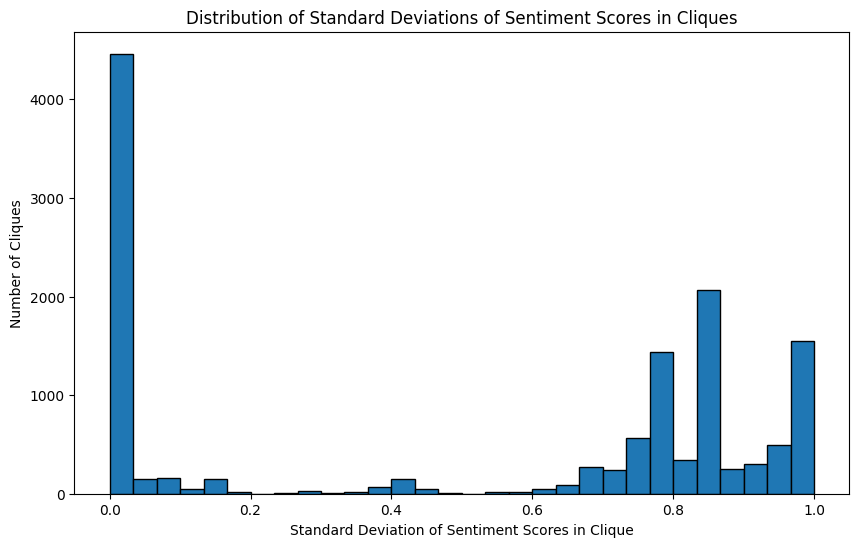

In [42]:
# histogram of distribution of standard deviations of sentiment scores in cliques
std_devs = []
for clique in filtered_cliques:
    sentiments = [G.nodes[node].get('sentiment_compound') for node in clique]
    std_dev = np.std(sentiments)
    std_devs.append(std_dev)
plt.figure(figsize=(10, 6))
plt.hist(std_devs, bins=30, edgecolor='black')
plt.xlabel('Standard Deviation of Sentiment Scores in Clique')
plt.ylabel('Number of Cliques')
plt.title('Distribution of Standard Deviations of Sentiment Scores in Cliques')
plt.show()

The plot above shows:

Large spike at 0: Over 2,000 cliques have a standard deviation near zero, meaning all members share very similar sentiment scores (high internal homogeneity).

Sparse middle range (0.2–0.6): Few cliques exhibit moderate variability in sentiment.

Secondary cluster near 0.8–1.0: Many cliques have very high variability, suggesting strong disagreement or mixed sentiment among members.

Hereby we see that the network has two dominant clique types, Highly homogeneous cliques (low variability) and highly heterogeneous cliques (high variability). Very few cliques fall in the middle, indicating polarization or strong thematic grouping.

## TF-IDF for 9-cliques
We would now like to dive a bit deeper into the semantics of the larger cliques. We do this by extracting all the 9-cliques, and calculate their sentiment and generate some wordclouds based on their TF-IDF scores.

In [34]:
# extract 9-cliques
from collections import defaultdict
nine_cliques = [clique for clique in cliques if len(clique) == 9]
print(f"Number of 9-cliques: {len(nine_cliques)}")

clique_sentiments = defaultdict(list)
for clique in nine_cliques:
    key = tuple(clique)
    for artist in clique:
        # calculate average sentiment
        sentiment = G.nodes[artist].get('sentiment_compound')
        clique_sentiments[key].append(float(sentiment))

# compute average sentiment per 9-clique and print sorted low->high
avg_by_clique = []
for key, sentiments in clique_sentiments.items():
    if sentiments:
        avg_sent = sum(sentiments) / len(sentiments)
        avg_by_clique.append((avg_sent, key))

# sort by average sentiment ascending (low -> high)
avg_by_clique.sort(key=lambda x: x[0])

for avg_sent, clique_key in avg_by_clique:
    print(f"Average Sentiment = {avg_sent:.4f} ; {list(clique_key)}")

Number of 9-cliques: 10
Average Sentiment = -0.3255 ; ['Twista', '2Pac', 'Bubba_Sparxxx', 'Busta_Rhymes', 'Trick_Daddy', 'Trina', 'Three_6_Mafia', 'Ludacris', 'Soulja_Boy']
Average Sentiment = -0.3231 ; ['Twista', '50_Cent', 'Soulja_Boy', 'Trina', 'Trick_Daddy', 'Three_6_Mafia', 'Ludacris', 'Lil_Jon', 'Fat_Joe']
Average Sentiment = -0.1109 ; ['Twista', '50_Cent', 'Soulja_Boy', 'Trina', 'Trick_Daddy', 'Three_6_Mafia', 'Sean_Paul', 'Lil_Jon', 'Fat_Joe']
Average Sentiment = -0.1034 ; ['Twista', '50_Cent', 'Soulja_Boy', 'Trina', 'Trick_Daddy', 'Three_6_Mafia', 'Ludacris', 'Busta_Rhymes', 'Bubba_Sparxxx']
Average Sentiment = 0.3363 ; ['Sylvan_Esso', 'Spoon', 'The_Kills', 'Lewis_Del_Mar', 'Kaskade', 'Atlas_Genius', 'Cloud_Nothings', 'Kaleo', 'Matt_and_Kim']
Average Sentiment = 0.3364 ; ['Sylvan_Esso', 'Spoon', 'The_Kills', 'Lewis_Del_Mar', 'Glass_Animals', 'Cloud_Nothings', 'Kaleo', 'Atlas_Genius', 'Matt_and_Kim']
Average Sentiment = 0.3372 ; ['Sylvan_Esso', 'Spoon', 'The_Kills', 'Lewis_Del_

Now we will make a TF-IDF analysis on the lowest and highest clique, with regards to sentiment inside the cliques.

In [35]:

from collections import Counter

# reuse notebook parameters if present, else set defaults
min_word_count = globals().get("min_word_count", 5)
top_k_per_cluster = globals().get("top_k_per_cluster", 200)
lemmatizer = globals().get("lemmatizer", None)
stopwords = globals().get("stopwords", None)

# ensure lemmatizer/stopwords available
if lemmatizer is None:
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
if stopwords is None:
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    stopwords = set(ENGLISH_STOP_WORDS)

# Compute TF-IDF for all 9-cliques
clique_partition = {}
for i, clique in enumerate(nine_cliques):
    for node in clique:
        clique_partition[node] = i

TF_lists_by_clique, TFIDF_lists_by_clique = compute_tf_tfidf_by_partition(
    G, clique_partition,
    stopwords, lemmatizer,
    min_word_count=min_word_count,
    top_k_per_cluster=top_k_per_cluster
)



Lowest Sentiment clique: ('Twista', '2Pac', 'Bubba_Sparxxx', 'Busta_Rhymes', 'Trick_Daddy', 'Trina', 'Three_6_Mafia', 'Ludacris', 'Soulja_Boy') with Avg Sentiment: -0.3255
Highest Sentiment clique: ('Carrie_Underwood', 'Blake_Shelton', 'Thompson_Square', 'Randy_Houser', 'Little_Big_Town', 'Cole_Swindell', 'Jason_Aldean', 'Jon_Pardi', 'Joe_Nichols') with Avg Sentiment: 0.9956



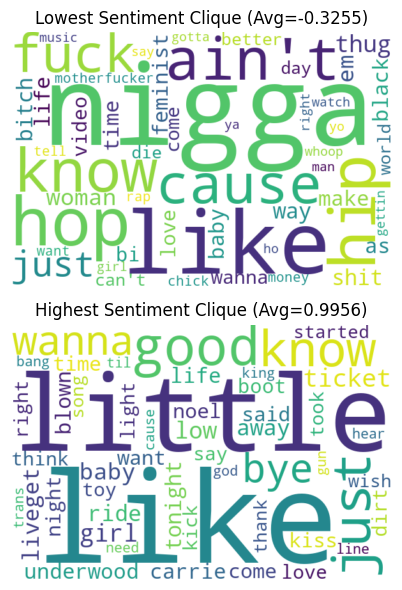

In [36]:
# print wordclouds and the sentiment score for the highest and lowest 9-cliques using plot_tf_vs_tfidf
lowest_clique_id = avg_by_clique[0][1]
highest_clique_id = avg_by_clique[-1][1]

print(f"\nLowest Sentiment clique: {lowest_clique_id} with Avg Sentiment: {avg_by_clique[0][0]:.4f}")
print(f"Highest Sentiment clique: {highest_clique_id} with Avg Sentiment: {avg_by_clique[-1][0]:.4f}\n")

plot_tf_vs_tfidf(
    TF_lists_by_clique,
    TFIDF_lists_by_clique,
    clusters=[clique_partition[lowest_clique_id[0]], clique_partition[highest_clique_id[0]]],
    NUM_WORDS=50,
    n=2,
    tf_title="TF (raw counts)",
    tfidf_title="TF-IDF (top terms)",
    wc_kwargs={"background_color":"white", "width":600, "height":400},
    figsize_per_row=(7,3),
    plot_tf=False,
    plot_tfidf=True,
    show_cluster_label=False,
    custom_titles={
        clique_partition[lowest_clique_id[0]]: f"Lowest Sentiment Clique (Avg={avg_by_clique[0][0]:.4f})",
        clique_partition[highest_clique_id[0]]: f"Highest Sentiment Clique (Avg={avg_by_clique[-1][0]:.4f})"
    }
)

Here it is easy to see that theres actually a big difference in how the sentiment relates to the words.
We see that the lowest sentiment clique are dominated by aggressive and confrontational words often used in rap and heavy hip-hop, with numerous profanities on the list of most used words.
In contrast the highest sentiment clique has a lot of postive and neutral words.

These two extremes show how cliques function as micro-clusters and because every artist inside a clique is directly linked to every other, the lyrical tone becomes unusually uniform.